In [2]:
import pandas as pd
import numpy as np
import random

# Modeling
from sklearn.metrics import mean_squared_error
import mlflow
from kernel_mf import MF_Recommender
    
mlflow.set_tracking_uri("http://localhost:5000")
rand_seed = 2
np.random.seed(rand_seed)
random.seed(rand_seed)

pd.options.display.max_rows = 100
pd.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2

First we load the data; current dataset has 31m ratings for 18k users. We rename the columns to the format expected by the MF library. We also construct a mapping from id to slug, and we then scale the ratings to the 0.5-5 range. I remove my own data from the movie_data which I'll pass in during the update.

In [5]:
ratings = pd.read_csv('data/ratings_v7.csv')

movie_data = ratings.rename(columns={'member_id': 'user_name', "film_id": "item_id"}).dropna()

def transform_ratings_and_compute_mean(df):
    # Map the rating to a 0.5-5 scale by normalizing the rating
    df = df.copy()
    df['rating'] = (df['rating'] - 1) * (4.5 / 9) + 0.5

    return df

training_data_scaled = transform_ratings_and_compute_mean(movie_data[movie_data.user_name!='ard_s'])
update_data_scaled = transform_ratings_and_compute_mean(movie_data[movie_data.user_name=='ard_s'])

print(f'training_data_scaled shape: {training_data_scaled.shape}')
print(training_data_scaled.head(5))

training_data_scaled shape: (41649212, 5)
      user_name  item_id                  slug  rating             alt_title
1  schaffrillas   882745              ne-zha-2     4.5              Ne Zha 2
2  schaffrillas  1096629                  obex     3.5                  OBEX
3  schaffrillas  1319258      johanne-sacreblu     5.0      Johanne Sacreblu
4  schaffrillas   586583    a-complete-unknown     3.0    A Complete Unknown
5  schaffrillas   844148  sonic-the-hedgehog-3     4.0  Sonic the Hedgehog 3


In [6]:
from backend.recommendation.utils import filter_users_by_rating_count
training_data_filtered = filter_users_by_rating_count(training_data_scaled, min_ratings=30, max_ratings=5000)

From 35122 users, 33862 have between 30 and 5000 ratings


In [52]:
from backend.recommendation.utils import downsample_to_minority

training_data_balanced = downsample_to_minority(training_data_filtered)

What is the purpose of this class?

The purpose of this class is to:
- train a matrix factorization model of varying kind (linear, sigmoid, rbf)
- test the model on a test set
- update the model for a new user and generate predictions

In order to do this, we need:
- methods to handle the rating data, transforming it into the appropriate format and splitting it
- methods to train the model with a provided set of hyperparameters
- methods to predict on a test set and compute a loss
- methods to update the model for a new user and generate predictions
- a dictionary to transform the members into numerical ids and back

What to figure out:
- best learning parameters
- how does reg affect the rankings other than preventing the model from overfitting?

## Single training run

In [ ]:
config = {
    "top_n_titles": 10000,
    "test_size": 0.2,
    "n_epochs": 20,
    "n_factors": 30,
    "kernel": "linear",
    "verbose": 1,
    "lr": 0.005,
    "reg": 0.01,
    "min_rating": 0.5,
    "max_rating": 5
}

SINGLE_RUN_TAG = 'BALANCED CLASSES AND FILTERED'

mlflow.end_run()
model = MF_Recommender(movie_data=training_data_balanced, config=config)
model.prepare_data(top_n_members=None)
model.train(single_run_tag=SINGLE_RUN_TAG)
model.test()

In [58]:
model.test()


Train RMSE: 0.5302
Train MAE: 0.5530


/Users/ardsnijders/Documents/cineville_scraper/env/lib/python3.9/site-packages/matrix_factorization/recommender_base.py:133: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[24296.  5535. 10536. ...  3378. 16770.  6904.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.




Test RMSE: 0.7529
Test MAE: 0.6518


In [59]:
test_results = model.get_test_results()

In [62]:
from backend.recommendation.utils import plot_error_vs_num_ratings

plot_error_vs_num_ratings(test_results)

In [45]:
from backend.recommendation.utils import plot_error_distribution_with_counts

plot_error_distribution_with_counts(df=test_results)

In [63]:
from backend.recommendation.utils import plot_error_distribution_with_counts

plot_error_distribution_with_counts(df=test_results)

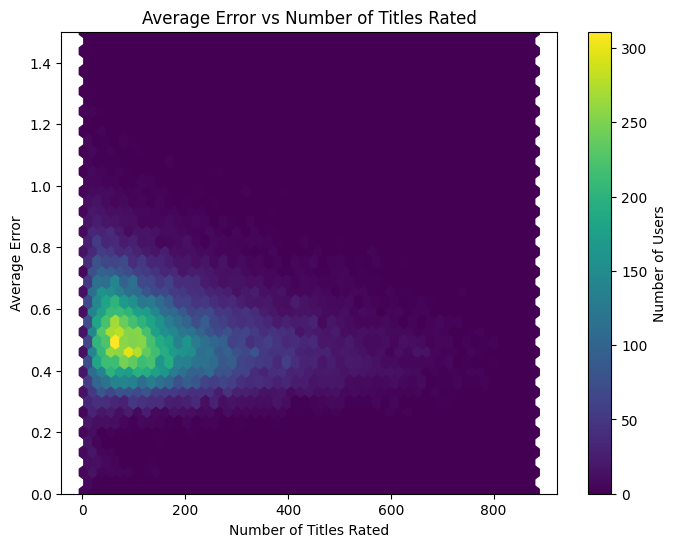

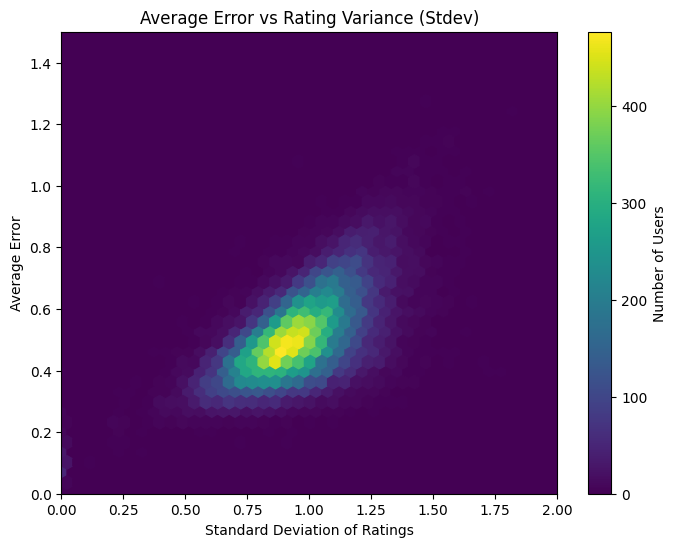

In [63]:
from backend.recommendation.utils import plot_avg_error_vs_num_ratings, plot_avg_error_vs_rating_variance

# Plot Average Error vs Number of Titles Rated
plot_avg_error_vs_num_ratings(df)

# Plot Average Error vs Rating Variance
plot_avg_error_vs_rating_variance(df)

## Grid search

In [ ]:
# All other params taken from config
param_grid = {
    'n_epochs': [20, 30, 40, 50],    # Epochs to test
    'lr': [0.01, 0.005, 0.001],   # Learning rates to test
    'reg': [0.005, 0.01, 0.02],  # Regularization strength to test
    'n_factors': [15, 20, 25, 30],   # Number of latent factors to test
    'kernel': ['linear'],
}

mlflow.end_run()

# RUN_TAG = 'GRID_SEARCH_MAE'

model = MF_Recommender(movie_data=training_data_scaled, config=config)
model.prepare_data(top_n_members=None)
model.grid_search(param_grid=param_grid, run_tag=RUN_TAG)

In [ ]:
user_history = update_data_scaled
recs = model.update_and_recommend(user_history=user_history, exclude_known=True)
recs = pd.DataFrame(recs)
recs['title'] = recs['item_id'].apply(lambda x: model.filmid2title[x])
recs.head(50)

## Per epoch development

In [ ]:
for epoch in range(1, 31):

    config = {
        "top_n_titles": 10000,
        "test_size": 0.2,
        "n_epochs": epoch,
        "n_factors": 30,
        "kernel": "linear",
        "verbose": 1,
        "lr": 0.005,
        "reg": 0.01,
        "min_rating": 0.5,
        "max_rating": 5
    }

    mlflow.end_run()
    model = MF_Recommender(movie_data=training_data_scaled, config=config)
    model.prepare_data(top_n_members=None)
    model.train()
    model.test()

    ratings_and_preds = pd.DataFrame(model.y_test)
    ratings_and_preds['pred'] = model.pred
    mean_squared_error(ratings_and_preds['rating'], ratings_and_preds['pred'])

    df = ratings_and_preds
    from backend.recommendation.utils import hexbin_plot, plot_prediction_errors
    hexbin_plot(df, epochs=epoch)